<a href="https://colab.research.google.com/github/elpeme/w281_final_project/blob/main/PK_W281_Vision_Transformers_Pre_Trained_Fine_Tuned_Coarse_Label_Checkpoints_Cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PK_W281_Vision_Transformers_Pre_Trained_Fine_Tuned_Coarse_Label_Checkpoints_Cifar100.ipynb

W281 Final Project

April 3, 2023

Waqas Ali | Pedro Melendez | Prakash Krishnan

### Introduction

Model Details:

Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224. 

The Vision Transformer (ViT) is a transformer encoder model (BERT-like) pretrained on a large collection of images in a supervised fashion, namely ImageNet-21k, at a resolution of 224x224 pixels. Next, the model was fine-tuned on ImageNet (also referred to as ILSVRC2012), a dataset comprising 1 million images and 1,000 classes, also at resolution 224x224.

Images are presented to the model as a sequence of fixed-size patches (resolution 16x16), which are linearly embedded. One also adds a [CLS] token to the beginning of a sequence to use it for classification tasks. One also adds absolute position embeddings before feeding the sequence to the layers of the Transformer encoder.

By pre-training the model, it learns an inner representation of images that can then be used to extract features useful for downstream tasks: if you have a dataset of labeled images for instance, you can train a standard classifier by placing a linear layer on top of the pre-trained encoder. One typically places a linear layer on top of the [CLS] token, as the last hidden state of this token can be seen as a representation of an entire image.


This model was fine tuned with a subset of Google Landmark dataset with only 20 categories with almost 1000 image each




# Import Libraries

In [1]:
import torch
print(torch.__version__)

In [2]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [3]:
import pandas as pd
import numpy as np
import time
import cv2
from PIL import Image as PILImage

import glob
import os

import tensorflow as tf
tf.random.set_seed(42)
print(tf.__version__)

import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

%matplotlib inline

from skimage.feature import hog
from sklearn.metrics import accuracy_score

from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops


from skimage.measure import shannon_entropy
import multiprocessing
from sklearn.model_selection import train_test_split
from datasets import Dataset
from datasets import load_dataset, Image, Features


from collections import Counter

2.6.5


# Building Huggingface Dataframe from Pandas

In [16]:
#### This was used to build the huggingface dataset from Pandas dataframe

# # Load the pandas dataframe from pickle file
# local_path = './'
# dataset_train, dataset_test = train_test_split(pd.read_pickle(local_path + "top_20_df_w_images_arrays.pkl"), test_size=0.2, random_state=42, shuffle=True)

## Test Dataset
# # Remove/rename image column
# dataset_test['image'] = dataset_test['tiny_image']
# dataset_test = dataset_test.drop(columns=['tiny_image'])

## Convert pandas to dic (Load directly from pandas never worked with error: ArrowInvalid: Can only convert 1-dimensional array values)
# test_dict = dataset_test.to_dict(orient='list')

## Training dataset
# dataset_train['image'] = dataset_train['tiny_image']
# dataset_train = dataset_train.drop(columns=['tiny_image'])
# train_dict = dataset_train.to_dict(orient='list')


# This step required a lot of memory it crahsed a VM wth 30GB of RAM for the train Dataset so I had to do it in batches of 1000 images
# test_hugging_dataset = Dataset.from_dict(test_dict).cast_column("image", Image())

# Batch sample for train dataset
# # Slice only 1000 images from dictionary
#     train_dict = dataset_train[:1000].to_dict(orient='list')
# # Create huggingface dataset for slice     
#     train_hugging_dataset_0_999 = Dataset.from_dict(train_dict).cast_column("image", Image())
# # Save to disk
#     full_set.save_to_disk("./hugging_face/train_hugging_dataset_0_999.hf")

# # Concatenate all slices into a full dataset
# full_set = concatenate_datasets([full_set, train_hugging_dataset_7000_8999, train_hugging_dataset_9000_9999, train_hugging_dataset_10000_10999, train_hugging_dataset_11000_11999, train_hugging_dataset_12000_end])


# # Save full training dataset to disk
# full_set.save_to_disk("./hugging_face/train_hugging_dataset_full.hf")

# # Save test dataset to disk
# test_hugging_dataset.save_to_disk("./hugging_face/test_hugging_dataset.hf")

# # Once the datasets are saved it can be loaded directly from disk
# dataset_train = Dataset.load_from_disk("./hugging_face/train_hugging_dataset_full.hf")
# dataset_test = Dataset.load_from_disk("./hugging_face/landmark_test_dataset.hf")

/home/jupyter/.local/lib/python3.9/site-packages/datasets/features/image.py:325: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


In [7]:
# # ViT model needs labels to start from 0 so I had to add a 'label' column to the datasets 
# label = [x for x in range(20)]
# landmarks = list(set(dataset_train['landmark_id']))
# label_map_landmark_id = dict(zip(landmarks,label))
# landmark_id_map_label = dict(zip(label, landmarks))
# def add_label(example):
#     # print(example)
#     example["label"] = label_map_landmark_id[example['landmark_id']]
#     return example

# dataset_train = dataset_train.map(add_label)
# dataset_test = dataset_test.map(add_label)

Loading cached processed dataset at /home/jupyter/gcs/w281/hugging_face/train_hugging_dataset_full.hf/cache-75f3ae92d3885785.arrow
Loading cached processed dataset at /home/jupyter/gcs/w281/hugging_face/landmark_test_dataset.hf/cache-90aea7f5727035bb.arrow


In [9]:
# # Save full training dataset to disk
# dataset_train.save_to_disk("./hugging_face/huggingface_dataset_train.hf")



# # Save test dataset to disk
# dataset_test.save_to_disk("./hugging_face/huggingface_dataset_test.hf")

Saving the dataset (0/2 shards):   0%|          | 0/13306 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3327 [00:00<?, ? examples/s]

## Loading Huggingface dataset from file

In [4]:
# Once the datasets are saved it can be loaded directly from disk
dataset_train = Dataset.load_from_disk("./hugging_face/huggingface_dataset_train.hf")
dataset_test = Dataset.load_from_disk("./hugging_face/huggingface_dataset_test.hf")

In [5]:
# Label and landmark_id mappinig to category name

# Used to build the dict to map landmark_id to category
# local_path = './'
# dataset_train, dataset_test = train_test_split(pd.read_pickle(local_path + "top_20_df_w_images_arrays.pkl"), test_size=0.2, random_state=42, shuffle=True)
# category_landmark_id = dict(dataset_test.groupby('category').apply(lambda df: df.sample(1))[['landmark_id','category']].values.tolist())

# Once created can be pulled directly from code:

category_landmark_id = {41648: 'Akkerman_fortress',
 20120: 'Catedral_San_Sebasti%C3%A1n,_Cochabamba',
 165596: 'Edinburgh_Castle',
 47378: 'Eiffel_Tower',
 9070: 'Feroz_Shah_Kotla',
 187779: 'Genoese_fortress_(Sudak)',
 168098: 'Golden_Gate_Bridge',
 46705: 'Grand_Canyon',
 176528: 'Haleakal%C4%81_National_Park',
 176018: 'Hayravank_monastery',
 36748: 'Kecharis',
 149980: 'Khotyn_Fortress',
 161902: 'Madrid_R%C3%ADo',
 120734: 'Mathura_Museum',
 1924: 'Niagara_Falls',
 139894: 'Pe%C5%A1ter',
 10419: 'Qutb_Minar_and_its_monuments,_Delhi',
 38482: 'Skopje_Fortress',
 45428: 'Sofiyivsky_Park',
 14915: 'St._Lawrence,_Toronto'}

label = [x for x in range(20)]
landmarks = list(set(dataset_train['landmark_id']))
label_map_landmark_id = dict(zip(landmarks,label))
landmark_id_map_label = dict(zip(label, landmarks))

In [6]:
# Test label to category name mapping 
def get_category_name(label):
    return category_landmark_id[landmark_id_map_label[label]]
test_label = 1
print(f'Label: {test_label} --> Category: {get_category_name(1)}')

Label: 1 --> Category: Niagara_Falls


In [7]:
# Validate all entries are still there
z = dataset_train['label']
Counter(z).most_common()


[(19, 767),
 (14, 763),
 (1, 754),
 (3, 735),
 (17, 718),
 (15, 718),
 (16, 704),
 (8, 695),
 (6, 689),
 (2, 688),
 (4, 666),
 (7, 655),
 (10, 635),
 (18, 613),
 (11, 613),
 (0, 598),
 (13, 591),
 (9, 590),
 (5, 571),
 (12, 543)]

In [8]:
# Validate all entries are still there
z = dataset_train['category']
Counter(z).most_common()


[('Pe%C5%A1ter', 767),
 ('Khotyn_Fortress', 763),
 ('Niagara_Falls', 754),
 ('Haleakal%C4%81_National_Park', 735),
 ('Grand_Canyon', 718),
 ('Feroz_Shah_Kotla', 718),
 ('Madrid_R%C3%ADo', 704),
 ('Golden_Gate_Bridge', 695),
 ('Catedral_San_Sebasti%C3%A1n,_Cochabamba', 689),
 ('Kecharis', 688),
 ('Hayravank_monastery', 666),
 ('Mathura_Museum', 655),
 ('Qutb_Minar_and_its_monuments,_Delhi', 635),
 ('Sofiyivsky_Park', 613),
 ('St._Lawrence,_Toronto', 613),
 ('Genoese_fortress_(Sudak)', 598),
 ('Edinburgh_Castle', 591),
 ('Akkerman_fortress', 590),
 ('Eiffel_Tower', 571),
 ('Skopje_Fortress', 543)]

{'id': '1d1b7350bd51f3fc', 'landmark_id': 47378, 'category': 'Eiffel_Tower', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FD3219A9D00>, 'label': 5}


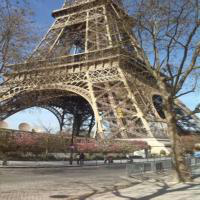

In [9]:
# Display random image 
print(dataset_test[19])
dataset_test[19]['image']


# Loading ViT Feature Extractor

We use google/vit-base-patch16-224-in21k model from the Hugging Face Hub.

The model is named as so as it refers to base-sized architecture with patch resolution of 16x16 and fine-tuning resolution of 224x224. 



In [52]:


# import model
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)


/home/jupyter/.local/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [53]:
# You can see the feature extractor configuration by printing it

feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

# Test the Mechanics of the Feature Extractor

In [54]:
# Pre-Process the raw image of 32 by 32
# pass the first image thru the feature extractor
# returns a pytorch tensors
# returns a dictionary with a single tensor

example = feature_extractor(
    np.asarray(dataset_train[0]['image']),
    return_tensors='pt'
)
example


{'pixel_values': tensor([[[[-0.0431, -0.0431, -0.0510,  ...,  0.5059,  0.5373,  0.5608],
          [-0.0510, -0.0588, -0.0588,  ...,  0.4980,  0.5294,  0.5529],
          [-0.0667, -0.0667, -0.0667,  ...,  0.4902,  0.5216,  0.5451],
          ...,
          [-0.5451, -0.5294, -0.5137,  ..., -0.4667, -0.4667, -0.5294],
          [-0.6000, -0.5686, -0.5216,  ..., -0.4745, -0.4745, -0.5373],
          [-0.6549, -0.5922, -0.5294,  ..., -0.4902, -0.4980, -0.5608]],

         [[-0.0588, -0.0588, -0.0667,  ...,  0.6078,  0.6392,  0.6627],
          [-0.0667, -0.0745, -0.0745,  ...,  0.6000,  0.6314,  0.6549],
          [-0.0824, -0.0824, -0.0824,  ...,  0.5922,  0.6314,  0.6471],
          ...,
          [-0.5686, -0.5451, -0.5373,  ..., -0.6863, -0.6863, -0.7490],
          [-0.6157, -0.5843, -0.5451,  ..., -0.7098, -0.7098, -0.7725],
          [-0.6706, -0.6235, -0.5608,  ..., -0.7255, -0.7333, -0.7961]],

         [[ 0.0431,  0.0431,  0.0353,  ...,  0.7098,  0.7490,  0.7882],
          [ 0

In [55]:
# Inspect the shape (one image, 3 channels, pixel values)
display(example['pixel_values'].shape)

# original image shape and size
display(np.asarray(dataset_train[0]['image']).size)

# YOU CAN SEE THE FEATURE EXTRACTOR RESIZES THE IMAGE FROM 32 by 32


torch.Size([1, 3, 224, 224])

120000

# Setup GPU

In [10]:
# load in relevant libraries, and alias where appropriate
# This block of code ensures we run it on GPU and NOT CPU

import torch

# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

# Data Pre-Processing for Vision Transformers

In [57]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['image'],
        return_tensors='pt'
    )

    # include the labels
    inputs['label'] = batch['label']
    return inputs

In [58]:
# Now, whenever you get an example from the dataset, the transform will be applied in real time (on both samples and slices).

# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)

# ... and the testing dataset
prepared_test = dataset_test.with_transform(preprocess)


In [59]:
# Inspect prepared_train and prepared_test

display(prepared_train[0])
display(prepared_train)

{'pixel_values': tensor([[[-0.0431, -0.0431, -0.0510,  ...,  0.5059,  0.5373,  0.5608],
          [-0.0510, -0.0588, -0.0588,  ...,  0.4980,  0.5294,  0.5529],
          [-0.0667, -0.0667, -0.0667,  ...,  0.4902,  0.5216,  0.5451],
          ...,
          [-0.5451, -0.5294, -0.5137,  ..., -0.4667, -0.4667, -0.5294],
          [-0.6000, -0.5686, -0.5216,  ..., -0.4745, -0.4745, -0.5373],
          [-0.6549, -0.5922, -0.5294,  ..., -0.4902, -0.4980, -0.5608]],
 
         [[-0.0588, -0.0588, -0.0667,  ...,  0.6078,  0.6392,  0.6627],
          [-0.0667, -0.0745, -0.0745,  ...,  0.6000,  0.6314,  0.6549],
          [-0.0824, -0.0824, -0.0824,  ...,  0.5922,  0.6314,  0.6471],
          ...,
          [-0.5686, -0.5451, -0.5373,  ..., -0.6863, -0.6863, -0.7490],
          [-0.6157, -0.5843, -0.5451,  ..., -0.7098, -0.7098, -0.7725],
          [-0.6706, -0.6235, -0.5608,  ..., -0.7255, -0.7333, -0.7961]],
 
         [[ 0.0431,  0.0431,  0.0353,  ...,  0.7098,  0.7490,  0.7882],
          [ 

Dataset({
    features: ['id', 'landmark_id', 'category', 'image', 'label'],
    num_rows: 13306
})

# Model Fine Tuning

In this section, we are going to build the Trainer, which is a feature-complete training and eval loop for PyTorch, optimized for HuggingFace 🤗 Transformers.

We need to define all of the arguments that it will include:
* training and testing dataset
* feature extractor
* model
* collate function
* evaluation metric
* ... other training arguments.

In [60]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

Let's now define the evaluation metric we are going to use to compare prediction with actual labels. We will use the *accuracy evaluation metric*. 

Accuracy is defined as the proportion of correct predictions (True Positive ($TP$) and True Negative ($TN$)) among the total number of cases processed ($TP$, $TN$, False Positive ($FP$), and False Negative ($FN$)). 

$$Accuracy = \frac{(TP + TN)}{(TP + TN + FP + FN)}$$    

Below, we are using accuracy within the ```compute_metrics``` function.

In [61]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

The last thing consists of defining ```TrainingArguments```.

Most of these are pretty self-explanatory, but one that is quite important here is ```remove_unused_columns=False```. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

We have chosen a batch size equal to 16, 100 evaluation steps, and a learning rate of $2e^{-4}$.

In [62]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./landmark", # output_dir (:obj:`str`): The output directory where the model predictions and checkpoints will be written.
  per_device_train_batch_size=16, # per_device_train_batch_size (:obj:`int`, `optional`, defaults to 8): The batch size per GPU/TPU core/CPU for training.
  evaluation_strategy="steps", # :obj:`"steps"`: Evaluation is done (and logged) every :obj:`eval_steps`.
  num_train_epochs=4, # Use 4
  save_steps=100, # Number of updates steps before two checkpoint saves. (Use 100)
  eval_steps=100, # Use 100
  logging_steps=10, # Number of update steps between two logs.
  learning_rate=2e-4, # learning_rate (:obj:`float`, `optional`, defaults to 5e-5):
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

We can now load the pre-trained model. We'll add num_labels on init so the model creates a classification head with the right number of units.

In [63]:
# VERY IMPORTANT ENTER THE NUMBER OF LABELS OR CLASSES


classes_count = len(set(dataset_train['label']))
print("Classes count: ', classes_count)

model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=classes_count # SEE NOTE ABOVE
)

display(model_id, classes_count)


20


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'google/vit-base-patch16-224-in21k'

20

In [11]:
# Assign to GPU

model.to(device)

NameError: name 'model' is not defined

In [65]:
# Setup Trainer Class

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

# Train the Model

In [12]:

filepath = './ViT_Models'

In [67]:

train_results = trainer.train()
# save tokenizer with the model
trainer.save_model(filepath)
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()


/home/jupyter/.local/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.970400,0.993184,0.822062
200,0.633200,0.525944,0.896904
300,0.410800,0.355690,0.914037
400,0.235700,0.325535,0.912834
500,0.330800,0.270420,0.927863
600,0.136000,0.290814,0.920048
700,0.234200,0.250574,0.932372
800,0.167300,0.246553,0.932071
900,0.177500,0.253066,0.932071
1000,0.061600,0.164173,0.955215


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



***** train metrics *****
  epoch                    =          4.0
  total_flos               = 3841797861GF
  train_loss               =       0.1686
  train_runtime            =  11:06:27.80
  train_samples_per_second =        1.331
  train_steps_per_second   =        0.083


# Model Evaluation

We can now evaluate our model using the accuracy metric defined above...

In [68]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9814
  eval_loss               =     0.0717
  eval_runtime            = 0:08:22.91
  eval_samples_per_second =      6.615
  eval_steps_per_second   =      0.827


# Evaluate an Example Test Image

In [13]:
# Load saved model
model_finetuned = ViTForImageClassification.from_pretrained(filepath)
# import features extractor
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(filepath)


def test_prediction(image):
    test_image_input = feature_extractor_finetuned(image, return_tensors="pt")
    with torch.no_grad():
        logits = model_finetuned(**test_image_input).logits
    predicted_label = logits.argmax(-1).item()
    return predicted_label

/home/jupyter/.local/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Actual label:  9
Actual category name:  Akkerman_fortress
Predicted label:  9
Predicted category:  Akkerman_fortress


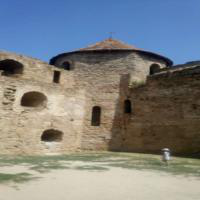

In [14]:
# show an image of the testing dataset
image_id = 700

test_image = dataset_test["image"][image_id]
actual_label = dataset_test["label"][image_id]
actual_category= dataset_test["category"][image_id]
predicted_label = test_prediction(test_image)

print('Actual label: ', actual_label) 
print('Actual category name: ', actual_category) 
print('Predicted label: ', predicted_label)
print('Predicted category: ', get_category_name(predicted_label))
test_image

In [42]:
def classify_external_image(input_image):

    single_image_set = Dataset.from_dict({'image': [input_image,]}).cast_column("image", Image())
    local_test_image = single_image_set[0]['image']
    
    predicted_label = test_prediction(local_test_image)
    print(f'Predicted label: {predicted_label} \nCategory:  {get_category_name(predicted_label)}')

Predicted label: 1 
Category:  Niagara_Falls


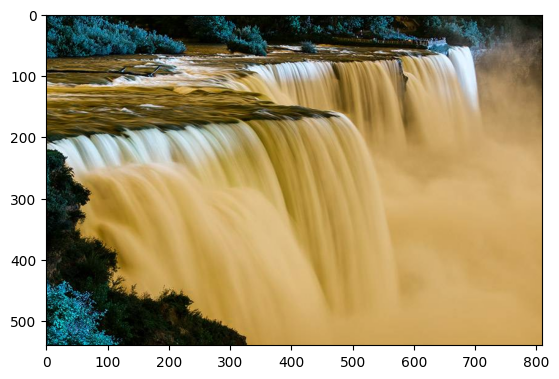

In [45]:
# Test with external image #1
external_test_image = cv2.imread('test_google_images/niagara.jpg')
classify_external_image(external_test_image)
plt.imshow(external_test_image)

## Even with the strange color to load with CV2, it was classified correctly

Predicted label: 1 
Category:  Niagara_Falls


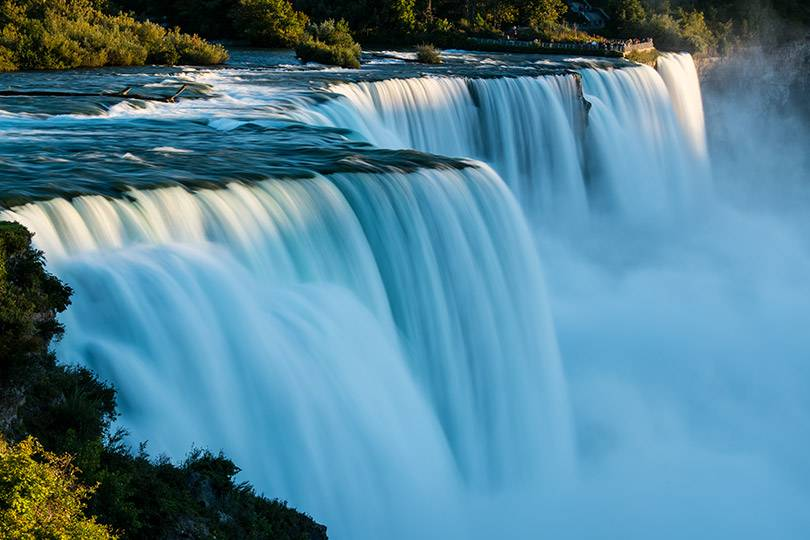

In [44]:
# Test with external image #1.1
# Same Niagara image but loading with PIL. Color looks ok and classification is correct too
external_test_image = PILImage.open('test_google_images/niagara.jpg')
classify_external_image(external_test_image)
external_test_image

Predicted label: 8 
Category:  Golden_Gate_Bridge


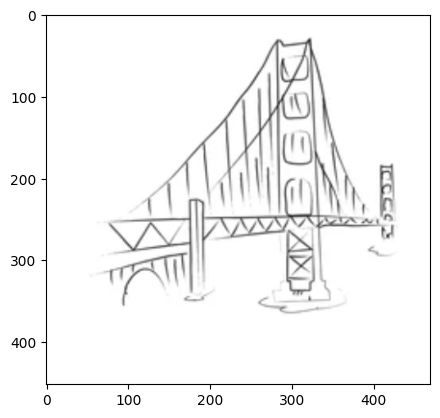

In [46]:
# Test 2

external_test_image = cv2.imread('test_google_images/golden gate draw black.png')
classify_external_image(external_test_image)
plt.imshow(external_test_image)


Predicted label: 5 
Category:  Eiffel_Tower


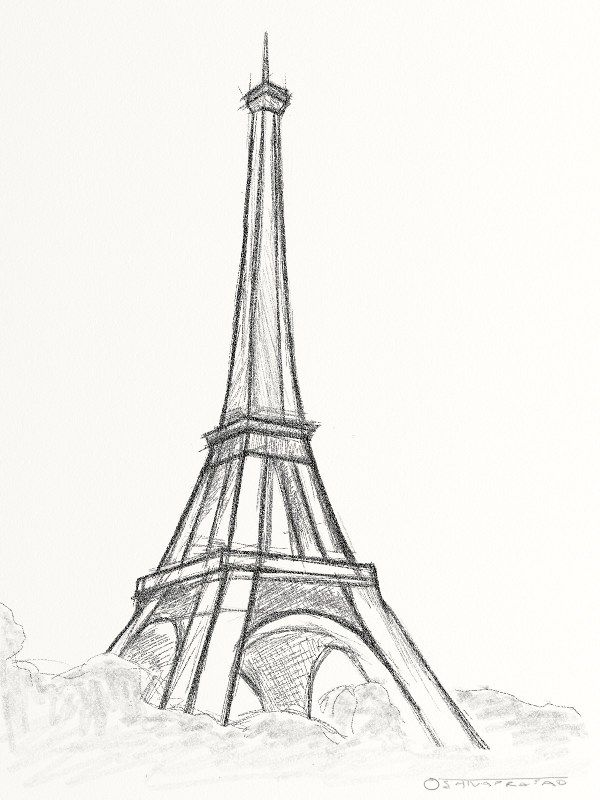

In [47]:
# Test 3 Eiffel Tower classified correctly 
external_test_image = PILImage.open('test_google_images/eiffel tower.jpg')
classify_external_image(external_test_image)
external_test_image

Predicted label: 8 
Category:  Golden_Gate_Bridge


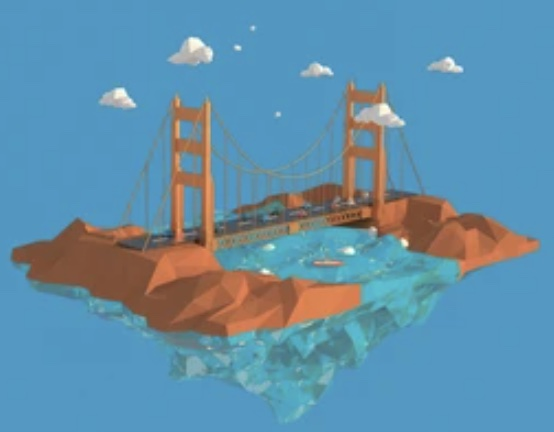

In [54]:
# Test 4 Golden Gate bridge is classified correctly when loading with PIL
external_test_image = PILImage.open('test_google_images/golden gate draw image.jpg')
classify_external_image(external_test_image)
external_test_image

Predicted label: 8 
Category:  Golden_Gate_Bridge


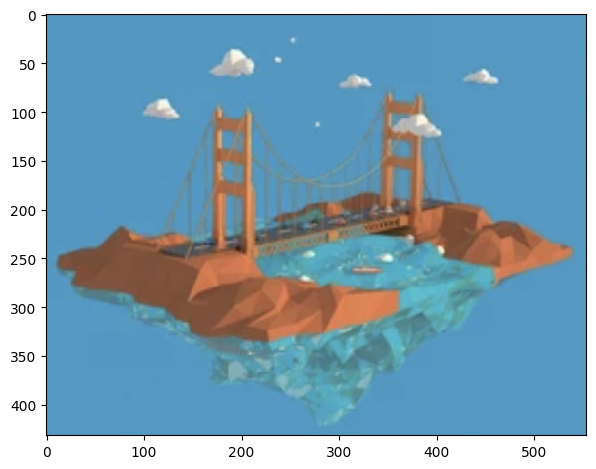

In [55]:
# Test 4.1 Golden Gate bridge is classified correctly when loading with skimage.io
from skimage import io

external_test_image = io.imread('test_google_images/golden gate draw image.jpg')

classify_external_image(external_test_image)

io.imshow(external_test_image)

Predicted label: 1 
Category:  Niagara_Falls


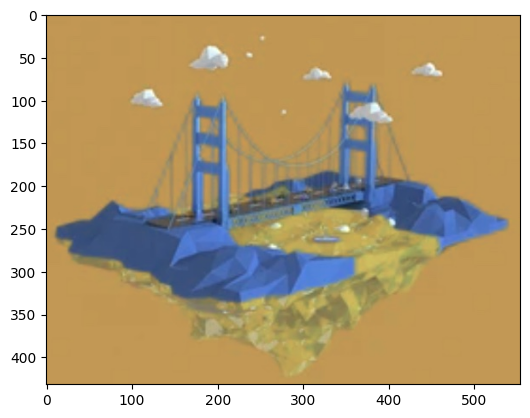

In [56]:
# Test 4.1 Golden Gate bridge is NOT classified correctly when loading with CV2 and image color does not look correct
external_test_image = cv2.imread('test_google_images/golden gate draw image.jpg')

classify_external_image(external_test_image)
plt.imshow(external_test_image)
